In [ ]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
SAVE = False
SEED = 111

tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

CLASS_TYPES = [ "agkistrodon-contortrix" ,  "agkistrodon-piscivorus" ,  "coluber-constrictor" ,
           "crotalus-atrox" ,  "crotalus-horridus" ,  "crotalus-ruber" ,  "crotalus-scutulatus" ,
           "crotalus-viridis" ,  "diadophis-punctatus" ,  "haldea-striatula" ,  "heterodon-platirhinos" ,
           "lampropeltis-californiae" ,  "lampropeltis-triangulum" ,  "masticophis-flagellum" ,
           "natrix-natrix" ,  "nerodia-erythrogaster" ,  "nerodia-fasciata" ,  "nerodia-rhombifer" ,
           "nerodia-sipedon" ,  "opheodrys-aestivus" ,  "pantherophis-alleghaniensis" ,
           "pantherophis-emoryi" ,  "pantherophis-guttatus" ,  "pantherophis-obsoletus" ,
           "pantherophis-spiloides" ,  "pantherophis-vulpinus" ,  "pituophis-catenifer" ,
           "rhinocheilus-lecontei" ,  "storeria-dekayi" ,  "storeria-occipitomaculata" ,
           "thamnophis-elegans" ,  "thamnophis-marcianus" ,  "thamnophis-proximus" ,
           "thamnophis-radix" ,  "thamnophis-sirtalis" , ]
N_TYPES = len(CLASS_TYPES)

In [ ]:
filelist=[]

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filelist.append(os.path.join(dirname,filename))


In [ ]:
len(filelist)

13185

In [ ]:
Filepaths= []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    Filepaths.append(image_file)
    labels.append(label)

In [ ]:
len(Filepaths), len(labels)

(13185, 13185)

In [ ]:
import pandas as pd
df = pd.DataFrame( list( zip (Filepaths, labels) ), columns = ['Filepath', 'Labels'] )
df

Filepath           Labels
0      /kaggle/input/identifying-different-breeds-of-...  nerodia-sipedon
1      /kaggle/input/identifying-different-breeds-of-...  nerodia-sipedon
2      /kaggle/input/identifying-different-breeds-of-...  nerodia-sipedon
3      /kaggle/input/identifying-different-breeds-of-...  nerodia-sipedon
4      /kaggle/input/identifying-different-breeds-of-...  nerodia-sipedon
...                                                  ...              ...
13180  /kaggle/input/identifying-different-breeds-of-...  storeria-dekayi
13181  /kaggle/input/identifying-different-breeds-of-...  storeria-dekayi
13182  /kaggle/input/identifying-different-breeds-of-...  storeria-dekayi
13183  /kaggle/input/identifying-different-breeds-of-...  storeria-dekayi
13184  /kaggle/input/identifying-different-breeds-of-...  storeria-dekayi

[13185 rows x 2 columns]

In [ ]:
from sklearn.utils import shuffle
df = (df.sample(frac = 1).reset_index()).drop(columns = 'index')
df


Filepath  \
0      /kaggle/input/identifying-different-breeds-of-...   
1      /kaggle/input/identifying-different-breeds-of-...   
2      /kaggle/input/identifying-different-breeds-of-...   
3      /kaggle/input/identifying-different-breeds-of-...   
4      /kaggle/input/identifying-different-breeds-of-...   
...                                                  ...   
13180  /kaggle/input/identifying-different-breeds-of-...   
13181  /kaggle/input/identifying-different-breeds-of-...   
13182  /kaggle/input/identifying-different-breeds-of-...   
13183  /kaggle/input/identifying-different-breeds-of-...   
13184  /kaggle/input/identifying-different-breeds-of-...   

                        Labels  
0          thamnophis-proximus  
1          pituophis-catenifer  
2        pantherophis-guttatus  
3          pituophis-catenifer  
4              storeria-dekayi  
...                        ...  
13180    rhinocheilus-lecontei  
13181    pantherophis-vulpinus  
13182  lampropeltis-triangulum  
13183     thamnophis-marcianus  
13184   pantherophis-obsoletus  

[13185 rows x 2 columns]

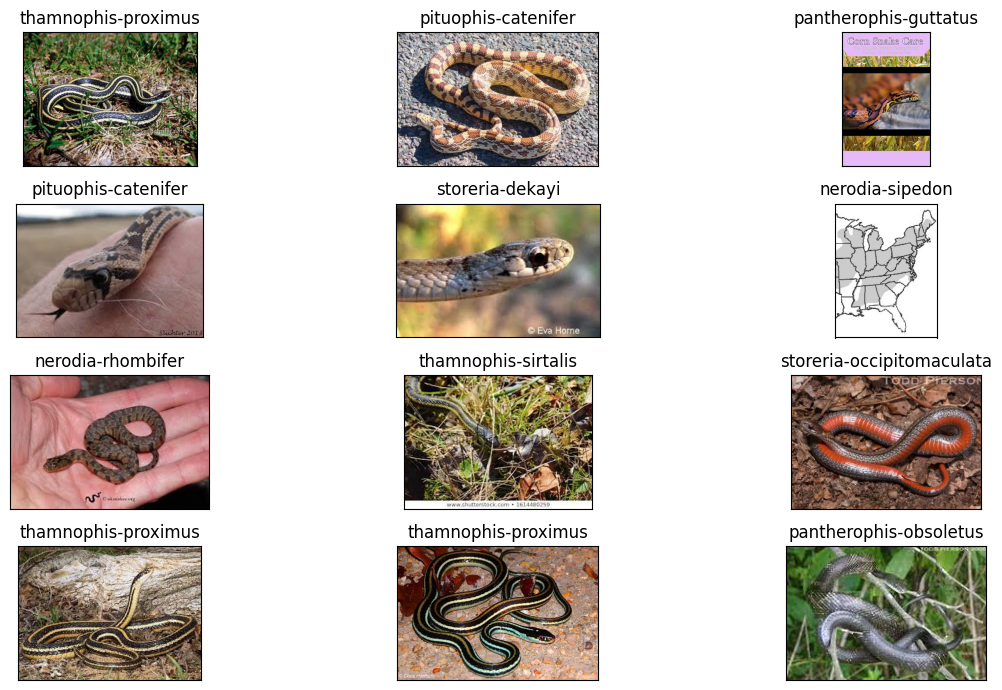

In [ ]:
import matplotlib.pyplot as plt

f,a = plt.subplots(nrows=4, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])

plt.tight_layout()
plt.show()

x reshaped: (1, 150, 150, 3)


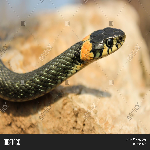

In [ ]:

im = load_img(df.Filepath[432], target_size=(150, 150))
im = img_to_array(im)


im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

im /= np.max(im)

im = array_to_img(im[0])
display(im)

In [ ]:
image_size = (150, 150)

batch_size = 32

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_ratio = .75
validation_ratio = 0.10
test_ratio = 0.25

train, test = train_test_split(df, test_size = test_ratio )
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio))


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                    x_col='Filepath', y_col='Labels',
                                                    target_size=image_size,
                                                    batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow_from_dataframe(dataframe = val,
                                                  x_col='Filepath', y_col='Labels',
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  shuffle=False)

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                  x_col='Filepath', y_col='Labels',
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 9888 validated image filenames belonging to 35 classes.
Found 942 validated image filenames belonging to 35 classes.
Found 2355 validated image filenames belonging to 35 classes.


In [ ]:
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'agkistrodon-contortrix': 0, 'agkistrodon-piscivorus': 1, 'coluber-constrictor': 2, 'crotalus-atrox': 3, 'crotalus-horridus': 4, 'crotalus-ruber': 5, 'crotalus-scutulatus': 6, 'crotalus-viridis': 7, 'diadophis-punctatus': 8, 'haldea-striatula': 9, 'heterodon-platirhinos': 10, 'lampropeltis-californiae': 11, 'lampropeltis-triangulum': 12, 'masticophis-flagellum': 13, 'natrix-natrix': 14, 'nerodia-erythrogaster': 15, 'nerodia-fasciata': 16, 'nerodia-rhombifer': 17, 'nerodia-sipedon': 18, 'opheodrys-aestivus': 19, 'pantherophis-alleghaniensis': 20, 'pantherophis-emoryi': 21, 'pantherophis-guttatus': 22, 'pantherophis-obsoletus': 23, 'pantherophis-spiloides': 24, 'pantherophis-vulpinus': 25, 'pituophis-catenifer': 26, 'rhinocheilus-lecontei': 27, 'storeria-dekayi': 28, 'storeria-occipitomaculata': 29, 'thamnophis-elegans': 30, 'thamnophis-marcianus': 31, 'thamnophis-proximus': 32, 'thamnophis-radix': 33, 'thamnophis-sirtalis': 34}


In [ ]:
image_shape = (image_size[0], image_size[1], 3)

epochs = 25

steps_per_epoch = train_generator.samples // batch_size

validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 60
Batch size: 32
Steps Per Epoch: 309
Validation steps: 73


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [ ]:
import keras

model = models.Sequential([

    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.1, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 35)             │        17,955 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511,875 (1.95 MB)

 Trainable params: 511,875 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
# model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)
#                     callbacks=[model_es, model_rlr])

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


309/309 ━━━━━━━━━━━━━━━━━━━━ 104s 317ms/step - accuracy: 0.0339 - loss: 3.5492 - val_accuracy: 0.0881 - val_loss: 3.4147
Epoch 2/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 94s 297ms/step - accuracy: 0.0809 - loss: 3.3743 - val_accuracy: 0.1008 - val_loss: 3.3598
Epoch 3/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 295ms/step - accuracy: 0.1237 - loss: 3.2098 - val_accuracy: 0.1306 - val_loss: 3.2120
Epoch 4/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 296ms/step - accuracy: 0.1520 - loss: 3.0828 - val_accuracy: 0.1550 - val_loss: 3.1017
Epoch 5/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 295ms/step - accuracy: 0.1854 - loss: 2.9476 - val_accuracy: 0.1890 - val_loss: 2.9755
Epoch 6/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 293ms/step - accuracy: 0.2069 - loss: 2.8095 - val_accuracy: 0.2335 - val_loss: 2.7953
Epoch 7/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 293ms/step - accuracy: 0.2557 - loss: 2.6689 - val_accuracy: 0.2346 - val_loss: 2.8622
Epoch 8/25
309/309 ━━━━━━━━━━━━━━━━━━━━ 92s 289ms/step - accuracy: 0.2754 - loss: 2.5680 - va

In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")



73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.4332 - loss: 2.7303
Test Loss: 2.65146
Test Accuracy: 0.43921


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


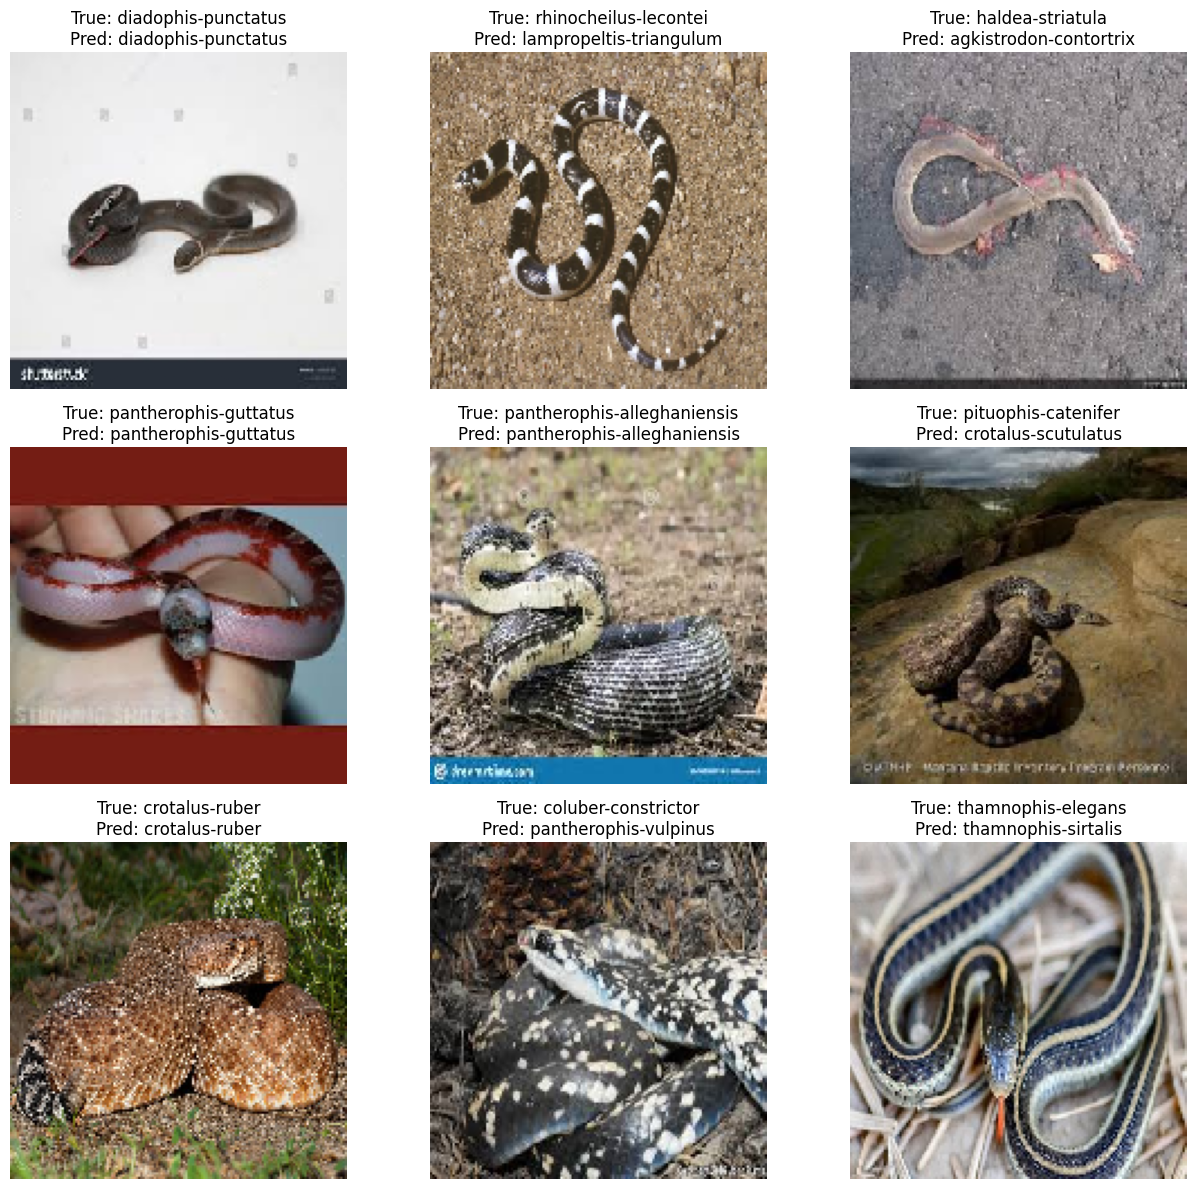

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(13, 12)):

    images, labels = next(test_generator)

    predictions = model.predict(images)

    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=figsize)

    for i, index in enumerate(indices):
        image = images[index]
        true_label = np.argmax(labels[index])
        pred_label = np.argmax(predictions[index])

        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), i + 1)
        plt.imshow(image)
        plt.title(f'True: {categories[true_label]}\nPred: {categories[pred_label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_predictions(
    model=model,
    test_generator=test_generator,
    categories=class_indices_train_list,
    test_dir=test_generator,
    num_samples=9,
    figsize=(13, 12)
)


In [ ]:
# Training the model [Epoch 60]
history = model.fit(train_generator,
                    epochs=60,
                    validation_data=val_generator)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


309/309 ━━━━━━━━━━━━━━━━━━━━ 100s 305ms/step - accuracy: 0.0348 - loss: 3.5379 - val_accuracy: 0.0456 - val_loss: 3.4656
Epoch 2/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 293ms/step - accuracy: 0.0626 - loss: 3.4098 - val_accuracy: 0.0722 - val_loss: 3.3855
Epoch 3/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 293ms/step - accuracy: 0.1051 - loss: 3.3136 - val_accuracy: 0.1019 - val_loss: 3.2956
Epoch 4/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 93s 294ms/step - accuracy: 0.1339 - loss: 3.1946 - val_accuracy: 0.1582 - val_loss: 3.1263
Epoch 5/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 94s 297ms/step - accuracy: 0.1639 - loss: 3.0364 - val_accuracy: 0.1635 - val_loss: 3.0646
Epoch 6/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 95s 301ms/step - accuracy: 0.1957 - loss: 2.8974 - val_accuracy: 0.2272 - val_loss: 2.8913
Epoch 7/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 94s 297ms/step - accuracy: 0.2279 - loss: 2.7698 - val_accuracy: 0.2219 - val_loss: 2.8558
Epoch 8/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 95s 299ms/step - accuracy: 0.2550 - loss: 2.6412 - va

In [ ]:
model.save("model.keras")

In [ ]:

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.5860 - loss: 3.3586
Test Loss: 3.43407
Test Accuracy: 0.58176


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


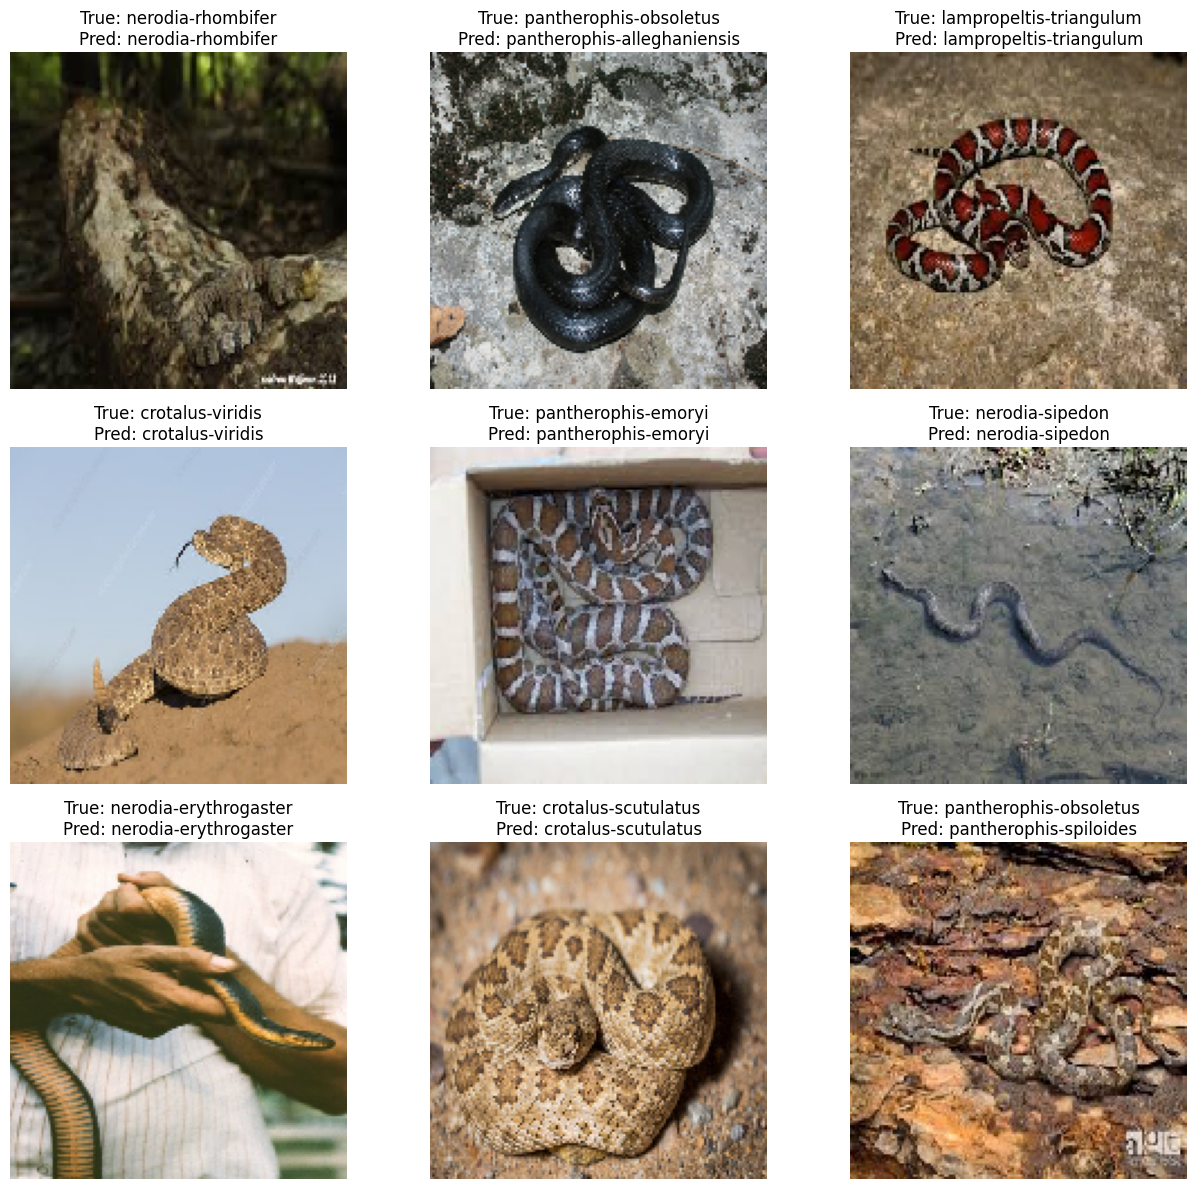

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(13, 12)):
    images, labels = next(test_generator)

    predictions = model.predict(images)

    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=figsize)

    for i, index in enumerate(indices):
        image = images[index]
        true_label = np.argmax(labels[index])
        pred_label = np.argmax(predictions[index])

        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), i + 1)
        plt.imshow(image)
        plt.title(f'True: {categories[true_label]}\nPred: {categories[pred_label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_predictions(
    model=model,
    test_generator=test_generator,
    categories=class_indices_train_list,
    test_dir=test_generator,
    num_samples=9,
    figsize=(13, 12)
)
